In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl 

In [14]:
df = pd.read_excel('data_for_sim.xlsx',sheet_name='Sheet3', engine = 'openpyxl')

df = df.reset_index(drop = True)


In [ ]:
#Probabilities

prob_uqr = .05        # Probability any officer will leave for a random reason.

col_prob_promo = .25  # Probability an LTC will be picked up for COL
ltc_prob_promo = .66  # Probability an MAJ will be picked up for LTC
maj_prob_promo = .80  # Probability a CPT will be picked up for MAJ

new_MAJ_each_year = 2 # Number of new MAJs assessed per year
new_CPT_each_year = 1 # Number of new CPTs assessed per year

total_years = 10      # Number of years to conduct the simulation

num_of_sims = 100     # Number of times run the monte carlo

#set up blank list of lists for collection later
LTC_by_year_grouping = [[] for year in range(total_years)]
MAJ_by_year_grouping = [[] for year in range(total_years)]
CPT_by_year_grouping = [[] for year in range(total_years)]


In [ ]:
for n in range(num_of_sims):
    
    # make new copy of df for each round of the sim
    df_copy = df.copy()

    #loop across each year
    for year in range(1,11):
        
        #Set up list to hold indices to remove
        removal_index = []

        #loop across each officer in current pool    
        for off_num in range(0,len(df_copy)):

            #account for UQR, if UQR probability is greater than a random number, 
            # add person's number to list for removal later
            if prob_uqr > np.random.random():
                removal_index.append(off_num)
                continue

            #account for retirement, if officer has money than two years,
            #compare likelyhood of retirement to a triangular distibution. 
            #If years of service is greater than tri distribution, add officer to removal list.
            if df_copy.loc[off_num,'YS'] >= 20:
                if df_copy.loc[off_num,'YS'] >= np.random.triangular(20,22,26):
                    removal_index.append(off_num)
                    continue

            #account for LTC to COL promotion
            #a certain number of LTCs will be promoted to Colonel.  If so, 
            # they will be dropped from this pool  Therefore is time in grade 
            # of a LTC is more than 5 years, check to see if this person will get promoted.
            if df_copy.loc[off_num,'TIG'] >= 5:
                if col_prob_promo >= np.random.random():
                    removal_index.append(off_num)
                    continue
            
                       
            #check promotion to LTC
            #If a Major has enough years in current grade (at least 6), check probability of promotion and then promote
            if (df_copy.loc[off_num,'rank'] == "MAJ") and (df_copy.loc[off_num,'TIG'] >=6 ) :
                if ltc_prob_promo > np.random.random():
                    df_copy.loc[off_num,'rank'] = "LTC"

            #check promotion to MAJ
            ##If a Captain has enough years in current grade (at least 8), check probability of promotion and then promote
            if (df_copy.loc[off_num,'rank'] == "CPT") and (df_copy.loc[off_num,"TIG"] >= 8):
                if maj_prob_promo > np.random.random():
                    df_copy.loc[off_num,'rank'] = "MAJ"

        #Remove officers
        #Of all the officers we added to the removal_index list (because of UQR, retirement, or promotion to COL), we now
        #remove them from the dataframe at the end of each year.
        df_copy = df_copy.drop(removal_index, axis = 0).reset_index(drop = True)
        
        
        
        #Add one year or service at end of year for all officers
        df_copy['YS'] += 1

        #Add one year time in grade at end of year for all officers
        df_copy['TIG'] += 1
        
       
        #Each year they assess new MAJs into program.  Add MAJs to dataframe
        for j in range(1,new_MAJ_each_year+1):
            maj_ys = int(round(np.random.triangular(12, 15, 18),2))
            maj_tig = maj_ys - 12
            new_maj = pd.DataFrame({'rank':'MAJ',
                      'YS': maj_ys,
                       'TIG': maj_tig
                      },index = [j]
                                  )
            df_copy = pd.concat([df_copy,new_maj], ignore_index = True)


        #Each year they assess new CPTs into program.  Add CPTs to dataframe
        for i in range(1,new_CPT_each_year+1):
            cpt_ys = int(round(np.random.triangular(6, 8, 11 ),2))
            cpt_tig = cpt_ys - 4
            new_cpt = pd.DataFrame({'rank':'CPT',
                      'YS': cpt_ys,
                       'TIG': cpt_tig
                      }, index = [i]
                      )
            df_copy = pd.concat([df_copy,new_cpt], ignore_index = True)

        
            
        #At the end of each year, add the number of LTCs, MAJs, and CPTs to their respective 
        # list of lists.  Each of these list of lists has 10 elements (one for each year of the sim) 
        #and then inside of those 10 elements is numbers of officers by rank by simulation.  Therefore. 
        # if there are 100 simulations across 10 years, there will be 10 sublists, each with 100 numbers.  
        # That way, we can do statistical analysis on the number of officers by rank by year if needed. 
        LTC_by_year_grouping[year-1].append(len(df_copy.loc[df_copy['rank'] == 'LTC'])) 
        MAJ_by_year_grouping[year-1].append(len(df_copy.loc[df_copy['rank'] == 'MAJ'])) 
        CPT_by_year_grouping[year-1].append(len(df_copy.loc[df_copy['rank'] == 'CPT'])) 
    



In [ ]:
#set up our collection dataframe that will be append to for each year
total_collection = pd.DataFrame(columns= ["Quantity",'Year','Rank'])

#with the list of lists created above, we need to "unlist" them and pull out 
#the number of officers, by rank, each year.  So we loop through the years (which aligns with the index of the list of lists)
#and then grab the number of officers in the particular rank per simulation.  
for i in range(total_years):
    
    holder_LTC = pd.DataFrame({"Quantity":LTC_by_year_grouping[i],
                          "Year": i + 2022,
                          "Rank": 'LTC'})
    
    holder_MAJ= pd.DataFrame({"Quantity":MAJ_by_year_grouping[i],
                          "Year": i + 2022,
                          "Rank": 'MAJ'})
        
    holder_CPT = pd.DataFrame({"Quantity":CPT_by_year_grouping[i],
                          "Year": i + 2022,
                          "Rank": 'CPT'})
    total_collection = pd.concat([total_collection, holder_LTC, holder_MAJ, holder_CPT])

#change the quantity column to integer type.
total_collection['Quantity']  = total_collection['Quantity'].astype(int)

Text(0.5, 1.0, 'Box Plot of FA49 Population after 10 years for 100 simulations.')

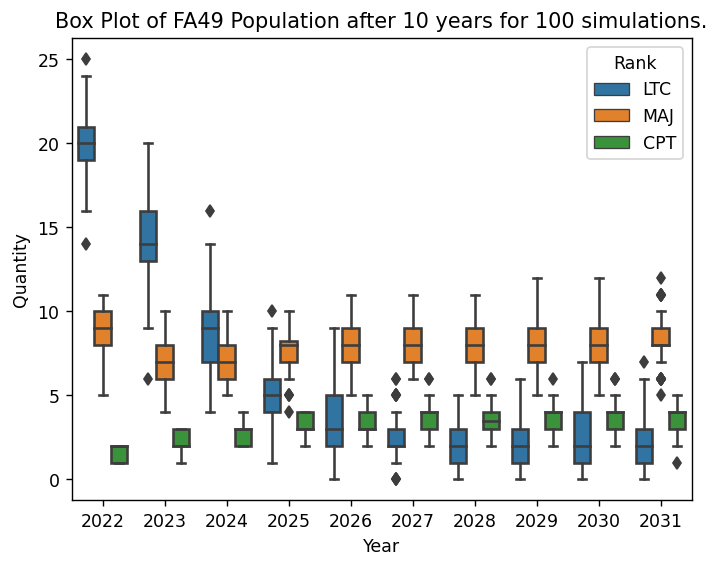

In [18]:
#box plot of the population of the officers over 100 simulations.

plt.rcParams['figure.dpi'] = 125


fig, ax = plt.subplots()
sns.boxplot(data = total_collection, x = 'Year', y = 'Quantity', hue = "Rank", ax = ax)
plt.title(f'Box Plot of Officer Population after 10 years for {num_of_sims} simulations.')



Text(0.5, 1.0, 'Bar plot of Officer Population after 10 years for 100 simulations.')

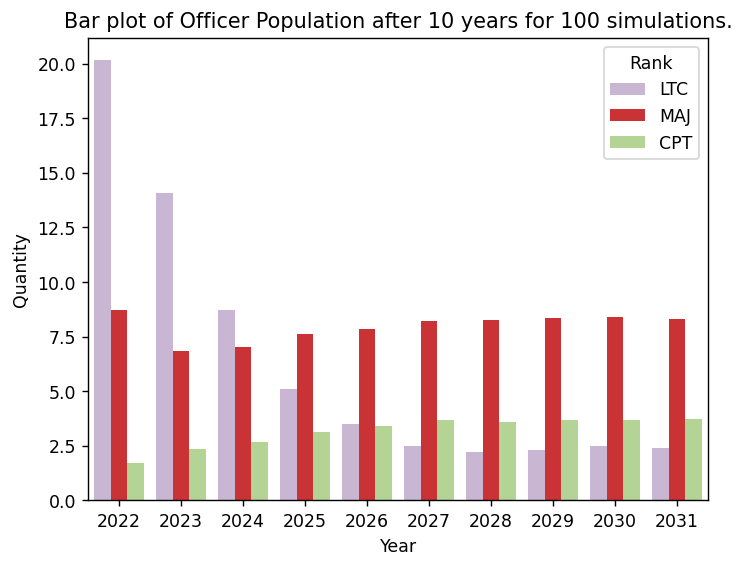

In [19]:
plt.rcParams['figure.dpi'] = 125


fig, ax = plt.subplots()
sns.barplot(data = total_collection, x = 'Year', y = 'Quantity', hue = "Rank", ax = ax, palette='Paired_r', ci = None,dodge = True )
plt.title(f'Bar plot of Officer Population after 10 years for {num_of_sims} simulations.')